In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from jaxlie import SE3, SO3

from sdf_world.sdf_world import *
from sdf_world.robots import *
from sdf_world.util import *

In [4]:
from flax import linen as nn
import optax
from flax.training.train_state import TrainState
import orbax
from flax.training import orbax_utils

In [5]:
manip_data = np.load("manip_data.npz")
manip_map = manip_data["manip_map"]
qtn_grids = manip_data["qtn_grids"]
xyz_grids = manip_data["xyz_grids"]

In [6]:
manip_map = manip_map / manip_map.max() #scale to 0-1

In [7]:
class ManipNet(nn.Module):
    hidden_dim: int
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return nn.softplus(x)

In [11]:
manip_net = ManipNet(64)
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.normal(key1, (7,))
params = manip_net.init(key2, jnp.zeros(7))
tx = optax.adam(learning_rate=0.001)
state = TrainState.create(
    apply_fn=manip_net.apply,
    params=params,
    tx=tx
)

In [12]:
def loss_fn(state:TrainState, params, inputs, labels):
    preds = state.apply_fn(params, inputs).flatten()
    return optax.l2_loss(preds, labels).mean()

@jax.jit
def update(state:TrainState, inputs, labels):
    losses, grads = jax.value_and_grad(loss_fn, argnums=1)(state, state.params, inputs, labels)
    state = state.apply_gradients(grads=grads)
    return state, losses

In [13]:
from IPython.display import clear_output
num_batch = 128
epochs = 10000
data_len = np.prod(manip_map.shape)
for i in range(epochs):
    #generate sample batch:
    qtn_idxs = np.random.randint(len(qtn_grids), size=num_batch)
    xyz_idxs = np.random.randint(len(xyz_grids), size=num_batch)
    inputs = jnp.hstack([qtn_grids[qtn_idxs], xyz_grids[xyz_idxs]])
    labels = jnp.asarray(manip_map[qtn_idxs, xyz_idxs])
    state, loss = update(state, inputs, labels)
    if i%100 == 0:
        clear_output(True)
        print(f"epoch{i}  loss: {loss.item()}")

epoch9900  loss: 0.0036299764178693295


In [17]:
trained_params = state.params

In [18]:
#save
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ckpt = {
    "params": trained_params
}
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('model/manip_net', ckpt, save_args=save_args, )

### Visualize

In [19]:
#load
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ckpt = orbax_checkpointer.restore('model/manip_net')
params = ckpt["params"]

#visualize
ws_r = 1.
ws_center = jnp.array([0,0,0.5])
def get_manip_value(wxyz_xyz):
    _, xyz = wxyz_xyz[:4], wxyz_xyz[4:]
    is_out_of_bound = jnp.linalg.norm(xyz - ws_center) > ws_r
    return jax.lax.cond(
        is_out_of_bound, lambda x:jnp.array([0.]), 
        lambda x: manip_net.apply(params, x), wxyz_xyz)

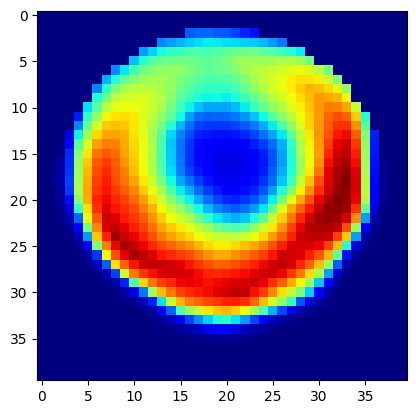

In [23]:
import matplotlib.pyplot as plt

qtn = np.random.normal(size=4)
qtn = qtn/np.linalg.norm(qtn)
rot = SO3(qtn)
z = 0.1

xx = np.linspace(-1, 1, 40)
yy = np.linspace(-1, 1, 40)
X, Y = np.meshgrid(xx, yy, indexing="ij")
xyz_samples = np.vstack([X.flatten(), Y.flatten(), np.full(40*40, z)]).T
qtn_samples = np.tile(qtn, len(xyz_samples)).reshape(-1, 4)
samples = jnp.hstack([qtn_samples, xyz_samples])
manips = jax.vmap(get_manip_value)(samples).flatten()
manips_xy = manips.reshape(40, -1)

plt.imshow(manips_xy, cmap="jet")

In [21]:
world = SDFWorld()
world.show_in_jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [24]:
panda_model = RobotModel(PANDA_URDF, PANDA_PACKAGE)
panda = Robot(world.vis, "panda", panda_model, alpha=0.5)

In [28]:
import matplotlib
cmap_jet = matplotlib.colormaps["jet"]
frame = Frame(world.vis, "frame")

In [65]:
ee = Frame(world.vis, "ee")
ee.set_pose(SE3(panda_model.fk_fn(panda_model.q)[-1]))

In [148]:
def get_meshgrid_samples(qtn, z):
    xx = np.linspace(-1, 1, 40)
    yy = np.linspace(-1, 1, 40)
    X, Y = np.meshgrid(xx, yy, indexing="ij")
    xyz_samples = np.vstack([X.flatten(), Y.flatten(), np.full(40*40, z)]).T
    qtn_samples = np.tile(qtn, len(xyz_samples)).reshape(-1, 4)
    samples = jnp.hstack([qtn_samples, xyz_samples])
    return samples

#qtn = np.random.normal(size=4)
#qtn = qtn/np.linalg.norm(qtn)
#rot = SO3(qtn)
rot = SO3.from_rpy_radians(-jnp.pi/2,np.pi/2,0)
qtn = rot.parameters()

samples_0_1 = get_meshgrid_samples(qtn, 0.2)
manips_0_1 = jax.vmap(get_manip_value)(samples_0_1).flatten()


samples_0_2 = get_meshgrid_samples(qtn, 0.8)
manips_0_2 = jax.vmap(get_manip_value)(samples_0_2).flatten()

#manips_xy = manips.reshape(40, -1)

# colors = cmap_jet(scaling(manips))[:,:3]
# manip_map_pc.reload(points=xyz_samples, color=colors)


In [147]:
#offset, scale = scaling(manips_0_1)
pc_size = 0.03
manip_map_pc_0_1 = PointCloud(
    world.vis, "pc01", size=pc_size, points=samples_0_1[:,4:], 
    color=cmap_jet(manips_0_1)[:,:3]
)
manip_map_pc_0_2 = PointCloud(
    world.vis, "pc02", size=pc_size, points=samples_0_2[:,4:], 
    color=cmap_jet(manips_0_2)[:,:3]
)
max_pose = SE3(samples_0_1[manips_0_1.argmax()] + jnp.array([0,0,0,0,0,0,0.1]))
frame.set_pose(max_pose)

In [146]:
del manip_map_pc_0_1, manip_map_pc_0_2

In [138]:
panda_model.lb[:7], panda_model.ub[:7]

(array([-2.9671, -1.8326, -2.9671, -3.1416, -2.9671, -0.0873, -2.9671]),
 array([2.9671, 1.8326, 2.9671, 0.    , 2.9671, 3.8223, 2.9671]))

In [144]:
res.x

array([-0.30446265,  0.48782283, -0.02528399, -1.86806819,  1.34702644,
        1.3384831 ,  1.53952219])

In [1]:
from scipy.optimize import minimize
from functools import partial
@jax.jit
def _pose_error(q, target_pose):
    q = jnp.hstack([q, 0.04, 0.04])
    ee_pose = SE3(panda_model.fk_fn(q)[-1])
    diff = target_pose.inverse()@ ee_pose
    return jnp.sum(diff.log() ** 2)
_pose_error_vg = jax.value_and_grad(_pose_error)

NameError: name 'jax' is not defined

In [143]:
pose_error = partial(_pose_error_vg, target_pose=max_pose)
res = minimize(pose_error, panda_model.neutral[:7], method="BFGS", jac=True, tol=0.01)
if res.success:
    panda.set_joint_angles(q = jnp.hstack([res.x, 0.04, 0.04]))
else:
    print(res.message)

In [49]:
del manip_map_pc